<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 4: Spatial Weights</h2>
<h3>IT University of Copenhagen, Spring 2023</h3>
<h3>Instructor: Ane Rahbek Vierø</h3>
</div>

This notebook was adapted from:
* A course on Geographic Data Science: https://darribas.org/gds_course/content/bE/lab_E.html

In this session we will be learning the ins and outs of one of the key pieces in spatial analysis: spatial weights matrices. These are structured sets of numbers that formalize geographical relationships between the observations in a dataset. Essentially, a spatial weights matrix of a given geography is a matrix of dimensions $N$ by $N$, where $N$ is the total number of observations:

$
W = \left(\begin{array}{cccc}
0 & w_{12} & \dots & w_{1N} \\
w_{21} & \ddots & w_{ij} & \vdots \\
\vdots & w_{ji} & 0 & \vdots \\
w_{N1} & \dots & \dots & 0 
\end{array} \right)
$

where each cell $w_{ij}$ contains a value that represents the degree of spatial contact or interaction between observations $i$ and $j$. A fundamental concept in this context is that of *neighbor* and *neighborhood*. By convention, elements in the diagonal ($w_{ii}$) are set to zero. A *neighbor* of a given observation $i$ is another observation with which $i$ has some degree of connection. In terms of $W$, $i$ and $j$ are thus neighbors if $w_{ij} > 0$. Following this logic, the neighborhood of $i$ will be the set of observations in the system with which it has a connection, or those observations with a weight greater than zero.

There are several ways to create such matrices, and many more to transform them so they contain an accurate representation that aligns with the way we understand spatial interactions between the elements of a system. In this session, we will introduce the most commonly used ones and will show how to compute them with `PySAL`.

## New library: splot

*"[splot](https://splot.readthedocs.io/en/latest/) connects spatial analysis done in PySAL to different popular visualization toolkits like matplotlib. The splot package allows you to create both static plots ready for publication and interactive visualizations for quick iteration and spatial data exploration. The primary goal of splot is to enable you to visualize popular PySAL objects and gives you different views on your spatial analysis workflow"*

In [1]:
import seaborn as sns
sns.set_theme()
import pandas as pd
from pysal.lib import weights
from libpysal.io import open as psopen
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from splot.libpysal import plot_spatial_weights

## Data

For this tutorial, we will use a dataset of the voting areas ('afstemningsområder') used in Danish elections. They are the smallest spatial unit that we have voting results for.

In [2]:
# Read the file
db = gpd.read_file("data/afstemningsomraader_dk.gpkg")
# Index table on the id
db.rename({"id.lokalId":"area_id"},axis=1, inplace=True) # First, let's rename the column to something a bit easier to write
assert len(db) == len(db.area_id.unique())
db = db.set_index("area_id",drop=False) # we use the id columns as index for easy access to our spatial weights 

# NOTE if the data set is too large for your laptop, you can uncomment the next code line and work on a smaller subset
# This will break the section on islands using block weights, but everything else should work
# Select subset for Roskilde
# db = db.loc[db.kommunekode.isin(['0265','0169','0253','0183'])]

# Display summary
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1384 entries, 711122 to 711036
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id.namespace              1384 non-null   object        
 1   area_id                   1384 non-null   object        
 2   status                    1384 non-null   object        
 3   geometristatus            1384 non-null   object        
 4   virkningFra               1384 non-null   datetime64[ns]
 5   virkningTil               0 non-null      datetime64[ns]
 6   virkningsaktoer           1384 non-null   object        
 7   forretningshaendelse      1384 non-null   object        
 8   registreringFra           1384 non-null   datetime64[ns]
 9   registreringTil           0 non-null      datetime64[ns]
 10  registreringsaktoer       1384 non-null   object        
 11  forretningsomraade        1384 non-null   object        
 12  forretning

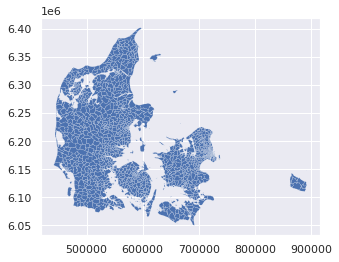

In [60]:
db.plot(linewidth=0.1); # because we've called sns.set_theme() our map looks slighty different with the default settings

In [61]:
db.head()

,id.namespace,area_id,status,geometristatus,virkningFra,virkningTil,virkningsaktoer,forretningshaendelse,registreringFra,registreringTil,...,afstemningsomraadenummer,afstemningsstedNavn,kommunekode,kommuneLokalId,opstillingskredsnummer,opstillingskredsLokalId,opstillingskreds,kommune,afstemningsstedAdresse,geometry
area_id,,,,,,,,,,,,,,,,,,,,,
711122,http://data.gov.dk/dagi,711122,vedtaget,endelig,2022-01-01T00:00:00,None,Næstved,ændretBekendtgørelse,2021-12-14T09:46:41,None,...,01,Fuglebjerg-hallen,0370,389148,32,403635,None,None,None,"MULTIPOLYGON (((662256.420 6139291.040, 661227..."
702240,http://data.gov.dk/dagi,702240,vedtaget,endelig,2019-12-17T00:00:00,None,Andet,systemetablering,2019-12-17T14:12:45,None,...,19,Højvangskolen,0751,389194,63,403608,None,None,None,"MULTIPOLYGON (((567630.850 6220468.380, 567689..."
711606,http://data.gov.dk/dagi,711606,vedtaget,endelig,2022-01-01T00:00:00,None,Slagelse,ændretBekendtgørelse,2021-12-14T09:46:41,None,...,01,Dalmosehallen,0330,389144,40,403630,None,None,None,"MULTIPOLYGON (((654711.620 6136586.760, 654494..."
711066,http://data.gov.dk/dagi,711066,vedtaget,endelig,2022-01-01T00:00:00,None,Tønder,ændretBekendtgørelse,2021-12-14T10:23:11,None,...,18,Arrild Medborgerhus,0550,389168,51,403619,None,None,None,"MULTIPOLYGON (((498103.090 6118415.800, 498043..."
707626,http://data.gov.dk/dagi,707626,vedtaget,endelig,2022-01-01T00:00:00,None,Haderslev,ændretBekendtgørelse,2021-12-14T10:23:11,None,...,02,Arnum Forsamlingshus,0510,389166,61,403617,None,None,None,"MULTIPOLYGON (((493342.980 6130822.280, 493337..."


## Building spatial weights in `PySAL`

### Contiguity

Contiguity weights matrices define spatial connections through the existence of common boundaries. This makes it directly suitable to use with polygons: if two polygons share boundaries to some degree, they will be labeled as neighbors under these kinds of weights. Exactly how much they need to share is what differenciates the two approaches we will learn: queen and rook.

#### Queen

Under the queen criteria, two observations only need to share a vortex (a single point) of their boundaries to be considered neighbors. Constructing a weights matrix under these principles can be done by running:

In [62]:
w_queen = weights.Queen.from_dataframe(db, idVariable="area_id")
w_queen

/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 34 disconnected components.
 There are 21 islands with ids: 701060, 701440, 701742, 702460, 702974, 703400, 703708, 704408, 704418, 704544, 706240, 706816, 707528, 708466, 708648, 709768, 709900, 709912, 710838, 711756, 711832.
  warnings.warn(message)


The command above creates an object `w_queen` of the class `W`. This is the format in which spatial weights matrices are stored in `PySAL`. By default, the weights builder (`Queen.from_dataframe`) will use the index of the table, which is useful so we can keep everything in line easily.

A `W` object can be queried to find out about the contiguity relations it contains. For example, if we would like to know who is a neighbor of observation `E01006690`:

In [63]:
w_queen['708518']  

{'701970': 1.0,
 '706412': 1.0,
 '700870': 1.0,
 '709938': 1.0,
 '703720': 1.0,
 '707896': 1.0,
 '718916': 1.0,
 '711110': 1.0,
 '703634': 1.0}

This returns a Python dictionary that contains the ID codes of each neighbor as keys, and the weights they are assigned as values. Since we are looking at a raw queen contiguity matrix, every neighbor gets a weight of one. If we want to access the weight of a specific neighbor, `709938` for example, we can do recursive querying:

In [64]:
w_queen['708518']['709938']

1.0

`W` objects also have a direct way to provide a list of all the neighbors or their weights for a given observation. This is thanks to the `neighbors` and `weights` attributes:

In [65]:
w_queen.neighbors['708518']

['701970',
 '706412',
 '700870',
 '709938',
 '703720',
 '707896',
 '718916',
 '711110',
 '703634']

In [66]:
w_queen.weights['708518']

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Once created, `W` objects can provide much information about the matrix, beyond the basic attributes one would expect. We have direct access to the number of neighbors each observation has via the attribute `cardinalities`. For example, to find out how many neighbors observation `E01006524` has:

In [67]:
w_queen.cardinalities['708518']

9

Since `cardinalities` is a dictionary, it is direct to convert it into a `Series` object:

In [68]:
queen_card = pd.Series(w_queen.cardinalities)
queen_card.head()

700760    9
700766    4
700772    4
700778    8
700784    5
dtype: int64

This allows, for example, to access quick plotting, which comes in very handy to get an overview of the size of neighborhoods in general:

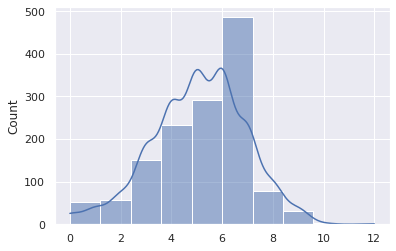

In [69]:
sns.histplot(queen_card, bins=10, kde=True); # stat="density"

The figure above shows how most observations have around 5 neighbors, but there is some variation around it. The distribution has a somewhat asymmetric form with more areas with below average neighbors - although deviations from the average occur both in higher and lower values.

Some additional information about the spatial relationships contained in the matrix are also easily available from a `W` object. Let us tour over some of them:

In [70]:
# Number of observations
w_queen.n

1384

In [71]:
# Average number of neighbors
w_queen.mean_neighbors

5.082369942196531

In [72]:
# Min number of neighbors
w_queen.min_neighbors

0

In [73]:
# Max number of neighbors
w_queen.max_neighbors

12

In [74]:
# Islands (observations disconnected)
w_queen.islands

['701060',
 '701440',
 '701742',
 '702460',
 '702974',
 '703400',
 '703708',
 '704408',
 '704418',
 '704544',
 '706240',
 '706816',
 '707528',
 '708466',
 '708648',
 '709768',
 '709900',
 '709912',
 '710838',
 '711756',
 '711832']

In [75]:
# Order of IDs (first five only in this case)
w_queen.id_order[:5]

['700760', '700766', '700772', '700778', '700784']

Spatial weight matrices can be explored visually in other ways. For example, we can pick an observation and visualize it in the context of its neighborhood. The following plot does exactly that by zooming into the surroundings of area '708518' (the voting area for Ishøj Forsamlingshus) and displaying its polygon as well as those of its neighbors:

In [76]:
db.loc[['708518']]

,id.namespace,area_id,status,geometristatus,virkningFra,virkningTil,virkningsaktoer,forretningshaendelse,registreringFra,registreringTil,...,afstemningsomraadenummer,afstemningsstedNavn,kommunekode,kommuneLokalId,opstillingskredsnummer,opstillingskredsLokalId,opstillingskreds,kommune,afstemningsstedAdresse,geometry
area_id,,,,,,,,,,,,,,,,,,,,,
708518,http://data.gov.dk/dagi,708518,vedtaget,endelig,2022-01-01T00:00:00,None,Ishøj,ændretBekendtgørelse,2021-12-14T11:34:24,None,...,01,Ishøj Forsamlingshus,0183,389118,18,403560,None,None,None,"MULTIPOLYGON (((709453.040 6170688.130, 709403..."


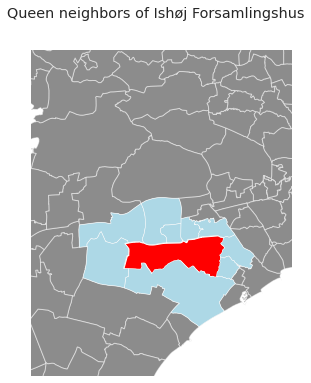

In [77]:
# Setup figure
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot base layer of polygons
db.plot(ax=ax, facecolor='k', linewidth=1, alpha=0.5)
# Select focal polygon
# NOTE we pass both the area code and the column name
#      (`geometry`) within brackets
focus = db.loc[['708518'], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=1, ax=ax)
# Plot neighbors
neis = db.loc[list(w_queen['708518'].keys()), :]
neis.plot(ax=ax, facecolor='lightblue', linewidth=0.5)
# Title
f.suptitle("Queen neighbors of Ishøj Forsamlingshus")
# Style and display on screen
ax.set_ylim(6160000, 6185000)
ax.set_xlim(695000, 715000)
ax.set_axis_off()
plt.show()

Note how the figure is built gradually, from the base map, to the focal point, and to its neighborhood. Once the entire figure is plotted, we zoom into the area of interest.

A final tip on exploring your spatial weights is the splot function `plot_spatial_weights`, which plots links between neighboring objects:

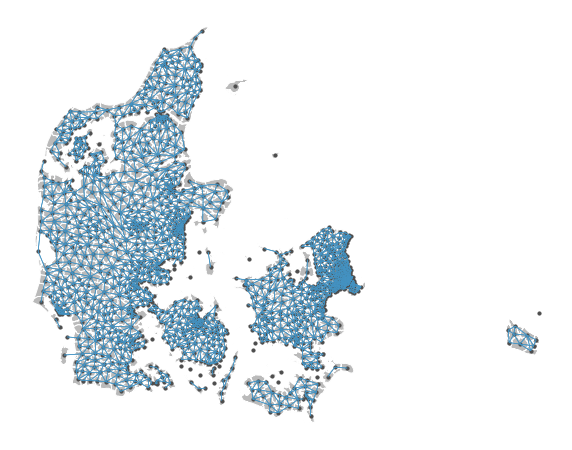

In [78]:
plot_spatial_weights(w_queen, db, indexed_on="area_id");

#### Rook

Rook contiguity is similar to and, in many ways, superseded by queen contiguity. However, since it sometimes comes up in the literature, it is useful to know about it. The main idea is the same: two observations are neighbors if they share some of their boundary lines. However, in the rook case, it is not enough with sharing only one point, it needs to be at least a segment of their boundary. In most applied cases, these differences usually boil down to how the geocoding was done, but in some cases, such as when we use raster data or grids, this approach can differ more substantively and it thus makes more sense.

From a technical point of view, constructing a rook matrix is very similar:

In [79]:
w_rook = weights.Rook.from_dataframe(db)
w_rook

/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 34 disconnected components.
 There are 21 islands with ids: 29, 78, 244, 308, 311, 531, 608, 609, 802, 850, 857, 908, 942, 964, 1034, 1074, 1143, 1193, 1278, 1323, 1347.
  warnings.warn(message)


The output is of the same type as before, a `W` object that can be queried and used in very much the same way as any other one.

### Distance

Distance based matrices assign the weight to each pair of observations as a function of how far from each other they are. How this is translated into an actual weight varies across types and variants, but they all share that the ultimate reason why two observations are assigned some weight is due to the distance between them.

#### K-Nearest Neighbors

One approach to define weights is to take the distances between a given observation and the rest of the set, rank them, and consider as neighbors the $k$ closest ones. That is exactly what the $k$-nearest neighbors (KNN) criterium does.

To calculate KNN weights, we can use a similar function as before:

In [80]:
knn5 = weights.KNN.from_dataframe(db, k=5)
knn5

/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


Note how we need to specify the number of nearest neighbors we want to consider with the argument `k`. Since it is a polygon geodataframe that we are passing, the function will automatically compute the centroids to derive distances between observations. Alternatively, we can provide the points in the form of an array:

In [81]:
# Extract centroids
cents = db.centroid
# Extract coordinates into an array
pts = pd.DataFrame(
    {"X": cents.x, "Y": cents.y}
).values
# Compute KNN weights
knn5_from_pts = weights.KNN.from_array(pts, k=5)
knn5_from_pts

/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


The warning here tells us that although the KNN approach ensures that all objects have K neighbors, in this case the result is still two disconnected components - meaning that no object in component one has a nearest neighbor in component two, and vice versa.

Can you guess which part of Denmark might end up in different components?
If we want to know, we can easily transfer information about the component to our original geodataframe.

In [82]:
knn5.component_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [83]:
db['component'] = knn5.component_labels
db.component.unique()

array([0, 1], dtype=int32)

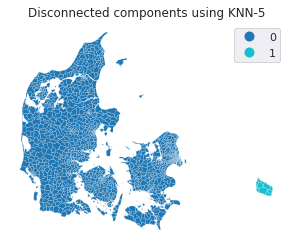

In [84]:
fig, ax = plt.subplots()
db.plot(ax=ax, column='component',categorical=True,legend=True,linewidth=0.1)
ax.set_title('Disconnected components using KNN-5')
ax.set_axis_off();

#### Distance band
 
Another approach to build distance-based spatial weights matrices is to draw a circle of certain radious and consider neighbor every observation that falls within the circle. The technique has two main variations: binary and continuous. In the former one, every neighbor is given a weight of one, while in the second one, the weights can be further tweaked by the distance to the observation of interest.

To compute binary distance matrices in `PySAL`, we can use the following command:

In [85]:
w_dist10kmB = weights.DistanceBand.from_dataframe(db, 10000)

/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 23 disconnected components.
 There are 16 islands with ids: 708648, 708972, 706240, 709344, 708906, 705128, 703350, 712176, 711832, 702974, 702460, 707768, 709154, 709020, 709888, 712094.
  warnings.warn(message)


This creates a binary matrix that considers neighbors of an observation every polygon whose centroid is closer than 10,000 metres (10Km) of the centroid of such observation. Notice the large distance: our areas are fairly large, so we have chosen a distance that will result in at least one neighbor for most objects.

Check, for example, the neighborhood of polygon `708518`:

In [86]:
w_dist10kmB['708518']

{'718916': 1.0,
 '703642': 1.0,
 '710708': 1.0,
 '704718': 1.0,
 '709130': 1.0,
 '709136': 1.0,
 '706090': 1.0,
 '700820': 1.0,
 '702064': 1.0,
 '708412': 1.0,
 '708406': 1.0,
 '701970': 1.0,
 '711110': 1.0,
 '703634': 1.0,
 '709780': 1.0,
 '703720': 1.0,
 '706412': 1.0,
 '707896': 1.0,
 '701852': 1.0,
 '701952': 1.0,
 '701958': 1.0,
 '718892': 1.0,
 '718910': 1.0,
 '718898': 1.0,
 '718922': 1.0,
 '700876': 1.0,
 '700870': 1.0,
 '709944': 1.0,
 '709938': 1.0,
 '710476': 1.0,
 '704396': 1.0,
 '704402': 1.0,
 '707090': 1.0,
 '707084': 1.0,
 '707962': 1.0,
 '702448': 1.0,
 '701896': 1.0,
 '703748': 1.0,
 '709762': 1.0}

Note that the units in which you specify the distance directly depend on the CRS in which the spatial data are projected. This has nothing to do with the weights building but it can affect it significantly. Recall how you can check the CRS of a `GeoDataFrame`:

In [87]:
db.crs

<Derived Projected CRS: EPSG:25832>
Name: ETRS89 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°E and 12°E: Austria; Belgium; Denmark - onshore and offshore; Germany - onshore and offshore; Norway including - onshore and offshore; Spain - offshore.
- bounds: (6.0, 38.76, 12.0, 84.33)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In this case, you can see the unit is expressed in metres (`m`), hence we set the threshold to 10,000 for a circle of 10km of radious.

An extension of the weights above is to introduce further detail by assigning different weights to different neighbors within the radious circle based on how far they are from the observation of interest. For example, we could think of assigning the inverse of the distance between observations $i$ and $j$ as $w_{ij}$. This can be computed with the following command:

In [88]:
w_dist10kmC = weights.DistanceBand.from_dataframe(db, 10000, binary=False)

/opt/conda/lib/python3.9/site-packages/scipy/sparse/_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In `w_dist10kmC`, every observation within the 10km circle is assigned a weight equal to the inverse distance between the two:

$$
w_{ij} = \dfrac{1}{d_{ij}}
$$

This way, the further apart $i$ and $j$ are from each other, the smaller the weight $w_{ij}$ will be.

Contrast the binary neighborhood with the continuous one for `708518`:

In [89]:
w_dist10kmC['708518']

{'718916': 0.00037241486049374413,
 '703642': 0.00010431389534239882,
 '710708': 0.0001653612941407463,
 '704718': 0.0001146715849365758,
 '709130': 0.00019303588075829535,
 '709136': 0.00016462430098409695,
 '706090': 0.00014101315140035747,
 '700820': 0.00012649278412678845,
 '702064': 0.00010224992335464217,
 '708412': 0.00010460315988837224,
 '708406': 0.0001128581115212207,
 '701970': 0.00019558997112980155,
 '711110': 0.0001827478868347447,
 '703634': 0.0005902156746230044,
 '709780': 0.00013755007101519815,
 '703720': 0.0002891633490348384,
 '706412': 0.00047442585407185263,
 '707896': 0.0003218164185792528,
 '701852': 0.0002497745066955046,
 '701952': 0.0001582111823296641,
 '701958': 0.00026538400066595207,
 '718892': 0.0001855313024366467,
 '718910': 0.0001656665782885482,
 '718898': 0.00017982721194253638,
 '718922': 0.00014529771464061802,
 '700876': 0.00020079488488555693,
 '700870': 0.00022113607110548308,
 '709944': 0.0001570641843026539,
 '709938': 0.0002539802366580732

Following this logic of more detailed weights through distance, there is a temptation to take it further and consider everyone else in the dataset as a neighbor whose weight will then get modulated by the distance effect shown above. However, although conceptually correct, this approach is not always the most computationally or practical one. Because of the nature of spatial weights matrices, particularly because of the fact their size is $N$ by $N$, they can grow substantially large. A way to cope with this problem is by making sure they remain fairly *sparse* (with many zeros). Sparsity is typically ensured in the case of contiguity or KNN by construction but, with inverse distance, it needs to be imposed as, otherwise, the matrix could be potentially entirely dense (no zero values other than the diagonal). In practical terms, what is usually done is to impose a distance threshold beyond which no weight is assigned and interaction is assumed to be non-existent. Beyond being computationally feasible and scalable, results from this approach usually do not differ much from a fully "dense" one as the additional information that is included from further observations is almost ignored due to the small weight they receive. In this context, a commonly used threshold, although not always best, is that which makes every observation to have at least one neighbor. 

Such a threshold can be calculated as follows:

In [90]:
min_thr = weights.min_threshold_distance(pts)
min_thr

53310.82392118661

Which can then be used to calculate an inverse distance weights matrix:

In [91]:
w_min_dist = weights.DistanceBand.from_dataframe(db, round(min_thr), binary=False)

/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In this case the minimim distance is fairly large - more than 53 kilometers - because of some of the more isolated islands. To avoid having such a large distance band, we can consider using a different method for finding neighbors to the islands (e.g. KNN).

### Block weights

Block weights connect every observation in a dataset that belongs to the same category in a list provided ex-ante. Usually, this list will have some relation to geography in the location of the observations but, technically speaking, all one needs to create block weights is a list of memberships. In this class of weights, neighboring observations, those in the same group, are assigned a weight of one, and the rest receive a weight of zero.

In this example, we will build a spatial weights matrix that connects every voting areas with all the other ones in the same municipality.

In [92]:
db.head()

,id.namespace,area_id,status,geometristatus,virkningFra,virkningTil,virkningsaktoer,forretningshaendelse,registreringFra,registreringTil,...,afstemningsstedNavn,kommunekode,kommuneLokalId,opstillingskredsnummer,opstillingskredsLokalId,opstillingskreds,kommune,afstemningsstedAdresse,geometry,component
area_id,,,,,,,,,,,,,,,,,,,,,
711122,http://data.gov.dk/dagi,711122,vedtaget,endelig,2022-01-01T00:00:00,None,Næstved,ændretBekendtgørelse,2021-12-14T09:46:41,None,...,Fuglebjerg-hallen,0370,389148,32,403635,None,None,None,"MULTIPOLYGON (((662256.420 6139291.040, 661227...",0
702240,http://data.gov.dk/dagi,702240,vedtaget,endelig,2019-12-17T00:00:00,None,Andet,systemetablering,2019-12-17T14:12:45,None,...,Højvangskolen,0751,389194,63,403608,None,None,None,"MULTIPOLYGON (((567630.850 6220468.380, 567689...",0
711606,http://data.gov.dk/dagi,711606,vedtaget,endelig,2022-01-01T00:00:00,None,Slagelse,ændretBekendtgørelse,2021-12-14T09:46:41,None,...,Dalmosehallen,0330,389144,40,403630,None,None,None,"MULTIPOLYGON (((654711.620 6136586.760, 654494...",0
711066,http://data.gov.dk/dagi,711066,vedtaget,endelig,2022-01-01T00:00:00,None,Tønder,ændretBekendtgørelse,2021-12-14T10:23:11,None,...,Arrild Medborgerhus,0550,389168,51,403619,None,None,None,"MULTIPOLYGON (((498103.090 6118415.800, 498043...",0
707626,http://data.gov.dk/dagi,707626,vedtaget,endelig,2022-01-01T00:00:00,None,Haderslev,ændretBekendtgørelse,2021-12-14T10:23:11,None,...,Arnum Forsamlingshus,0510,389166,61,403617,None,None,None,"MULTIPOLYGON (((493342.980 6130822.280, 493337...",0


To build a block spatial weights matrix that connects as neighbors all the voting areas in the same municipality, we only require the mapping of codes. Using `PySAL`, this is a one-line task:

In [93]:
w_block = weights.block_weights(db['kommunekode'])

/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 99 disconnected components.
 There are 2 islands with ids: 964, 1074.
  warnings.warn(message)


In [94]:
w_block.islands

[964, 1074]

In this case, `PySAL` does not allow to pass the argument `idVariable` as above. As a result, observations are named after the the order the occupy in the list:

In [95]:
w_block[0]

{368: 1.0,
 369: 1.0,
 370: 1.0,
 371: 1.0,
 372: 1.0,
 373: 1.0,
 374: 1.0,
 375: 1.0,
 376: 1.0,
 377: 1.0,
 378: 1.0,
 379: 1.0,
 380: 1.0,
 381: 1.0,
 382: 1.0,
 383: 1.0,
 384: 1.0,
 385: 1.0,
 386: 1.0,
 387: 1.0,
 388: 1.0,
 389: 1.0,
 390: 1.0,
 391: 1.0,
 392: 1.0}

The first element is neighbor of observations a range of observations identified by an ID that we do not have in our original data, all of them with an assigned weight of 1. However, it is possible to correct this by using the additional method `remap_ids`:

In [96]:
w_block.remap_ids(db.index)

Now if you try `w_bloc[0]`, it will return an error. But if you query for the neighbors of an observation by its area id, it will work:

In [97]:
w_block['708518']

{'700876': 1.0, '700870': 1.0, '709944': 1.0, '709938': 1.0}

Now we can use the id of the islands to find the corresponding data points in our data set:

In [98]:
db.loc[w_block.islands,['navn','afstemningsstedNavn','kommune']]

,navn,afstemningsstedNavn,kommune
area_id,,,
702974,Christiansø,Gæstgiveriet,None
702460,Læsø,Læsø Hallen,None


And let's try one of those we identified as an island to confirm that we get an empty result:

In [99]:
w_block['702974']

{}

Remapping the ids also makes it easy to visually inspect the islands:

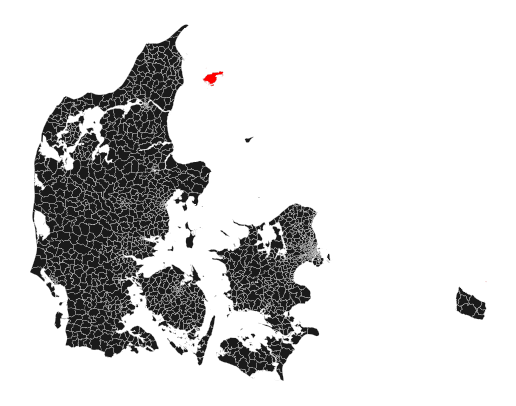

In [100]:
ax = db.plot(color='k', linewidth=0.2, figsize=(9, 9))
db.loc[w_block.islands, :].plot(color='red', linewidth=0.2, ax=ax)
ax.set_axis_off()

## Standardizing `W` matrices

In the context of many spatial analysis techniques, a spatial weights matrix with raw values (e.g. ones and zeros for the binary case) is not always the best one for analysis and some sort of transformation is required. This implies modifying each weight so they conform to certain rules. `PySAL` has transformations baked right into the `W` object, so it is possible to check the state of an object as well as to modify it.

Consider the original queen weights, for observation `708518`:

In [101]:
w_queen['708518']

{'701970': 1.0,
 '706412': 1.0,
 '700870': 1.0,
 '709938': 1.0,
 '703720': 1.0,
 '707896': 1.0,
 '718916': 1.0,
 '711110': 1.0,
 '703634': 1.0}

Since it is contiguity, every neighbor gets one, the rest zero weight. We can check if the object `w_queen` has been transformed or not by calling the argument `transform`:

In [102]:
w_queen.transform

'O'

where `O` stands for "original", so no transformations have been applied yet. If we want to apply a row-based transformation, so every row of the matrix sums up to one, we modify the `transform` attribute as follows:

In [103]:
w_queen.transform = 'R'

('WARNING: ', '708648', ' is an island (no neighbors)')
('WARNING: ', '701060', ' is an island (no neighbors)')
('WARNING: ', '706240', ' is an island (no neighbors)')
('WARNING: ', '709768', ' is an island (no neighbors)')
('WARNING: ', '703708', ' is an island (no neighbors)')
('WARNING: ', '708466', ' is an island (no neighbors)')
('WARNING: ', '704408', ' is an island (no neighbors)')
('WARNING: ', '704418', ' is an island (no neighbors)')
('WARNING: ', '703400', ' is an island (no neighbors)')
('WARNING: ', '709900', ' is an island (no neighbors)')
('WARNING: ', '706816', ' is an island (no neighbors)')
('WARNING: ', '709912', ' is an island (no neighbors)')
('WARNING: ', '711832', ' is an island (no neighbors)')
('WARNING: ', '702974', ' is an island (no neighbors)')
('WARNING: ', '701742', ' is an island (no neighbors)')
('WARNING: ', '702460', ' is an island (no neighbors)')
('WARNING: ', '711756', ' is an island (no neighbors)')
('WARNING: ', '704544', ' is an island (no neigh

Now we can check the weights of the same observation as above and find they have been modified:

In [104]:
w_queen['708518']

{'701970': 0.1111111111111111,
 '706412': 0.1111111111111111,
 '700870': 0.1111111111111111,
 '709938': 0.1111111111111111,
 '703720': 0.1111111111111111,
 '707896': 0.1111111111111111,
 '718916': 0.1111111111111111,
 '711110': 0.1111111111111111,
 '703634': 0.1111111111111111}

Save for precision issues, the sum of weights for all the neighbors is one:

In [105]:
pd.Series(w_queen['708518']).sum()

1.0

Returning the object back to its original state involves assigning `transform` back to original:

In [106]:
w_queen.transform = 'O'

In [107]:
w_queen['708518']

{'701970': 1.0,
 '706412': 1.0,
 '700870': 1.0,
 '709938': 1.0,
 '703720': 1.0,
 '707896': 1.0,
 '718916': 1.0,
 '711110': 1.0,
 '703634': 1.0}

`PySAL` supports the following transformations:

* `O`: original, returning the object to the initial state.
* `B`: binary, with every neighbor having assigned a weight of one.
* `R`: row, with all the neighbors of a given observation adding up to one.
* `V`: variance stabilizing, with the sum of all the weights being constrained to the number of observations.

## Spatial Lag

One of the most direct applications of spatial weight matrices is the so-called *spatial lag*. The spatial lag of a given variable is the product of a spatial weight matrix and the variable itself:

$$
Y_{sl} = W Y
$$

where $Y$ is a Nx1 vector with the values of the variable. Recall that the product of a matrix and a vector equals the sum of a row by column element multiplication for the resulting value of a given row. In terms of the spatial lag:

$$
y_{sl-i} = \displaystyle \sum_j w_{ij} y_j
$$

If we are using row-standardized weights, $w_{ij}$ becomes a proportion between zero and one, and $y_{sl-i}$ can be seen as the average value of $Y$ in the neighborhood of $i$.

For this illustration, we will use the area of each polygon as the variable of interest. And to make things a bit nicer later on, we will keep the log of the area instead of the raw measurement. Hence, let's create a column for it:

In [108]:
db["area"] = np.log(db.area)

The spatial lag is a key element of many spatial analysis techniques, as we will see later on and, as such, it is fully supported in `PySAL`. To compute the spatial lag of a given variable, `area` for example:

In [109]:
# Row-standardize the queen matrix
w_queen.transform = 'R'
# Compute spatial lag of `area`
w_queen_score = weights.lag_spatial(w_queen, db["area"])
# Print the first five elements
w_queen_score[:5]

array([17.21063591, 16.57802961, 16.87646316, 17.67330521, 16.88405134])

Line 4 contains the actual computation, which is highly optimized in `PySAL`. Note that, despite passing in a `pd.Series` object, the output is a `numpy` array. This however, can be added directly to the table `db`:

In [110]:
db['w_area'] = w_queen_score
db[['area','w_area']]

,area,w_area
area_id,,
711122,18.407526,17.210636
702240,15.701218,16.578030
711606,17.176829,16.876463
711066,17.834060,17.673305
707626,17.787859,16.884051
...,...,...
706166,13.887247,16.392516
702208,15.615791,16.248382
700984,14.972654,16.012874


## Optional: Reading and Writing spatial weights in `PySAL`

Sometimes, if a dataset is very detailed or large, it can be costly to build the spatial weights matrix of a given geography and, despite the optimizations in the `PySAL` code, the computation time can quickly grow out of hand. In these contexts, it is useful to not have to re-build a matrix from scratch every time we need to re-run the analysis. A useful solution in this case is to build the matrix once, and save it to a file where it can be reloaded at a later stage if needed.

`PySAL` has a common way to write any kind of `W` object into a file using the command `open`. The only element we need to decide for ourselves beforehand is the format of the file. Although there are several formats in which spatial weight matrices can be stored, we will focused on the two most commonly used ones:
* **`.gal`** files for contiguity weights

Contiguity spatial weights can be saved into a `.gal` file with the following commands:

In [111]:
# Open file to write into
fo = psopen('imd_queen.gal', 'w')
# Write the matrix into the file
fo.write(w_queen)

# Close the file
fo.close()

The process is composed by the following three steps:

1. Open a target file for `w`riting the matrix, hence the `w` argument. In this case, if a file `imd_queen.gal` already exists, it will be overwritten, so be careful.
1. Write the `W` object into the file.
1. Close the file. This is important as some additional information is written into the file at this stage, so failing to close the file might have unintended consequences.

Once we have the file written, it is possible to read it back into memory with the following command:

In [112]:
w_queen2 = psopen('imd_queen.gal', 'r').read()
w_queen2

/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 34 disconnected components.
 There are 21 islands with ids: 701060, 701440, 701742, 702460, 702974, 703400, 703708, 704408, 704418, 704544, 706240, 706816, 707528, 708466, 708648, 709768, 709900, 709912, 710838, 711756, 711832.
  warnings.warn(message)


Note how we now use `r` instead of `w` because we are `r`eading the file, and also notice how we open the file and, in the same line, we call `read()` directly.
* **`.gwt`** files for distance-based weights.

A very similar process to the one above can be used to read and write distance based weights. The only difference is specifying the right file format, `.gwt` in this case. So, if we want to write `w_dist1km` into a file, we will run:

In [113]:
# Open file
fo = psopen('imd_dist10km.gwt', 'w')
# Write matrix into the file
fo.write(w_dist10kmC)
# Close file
fo.close()

And if we want to read the file back in, all we need to do is:

In [114]:
w_dist10km2 = psopen('imd_dist10km.gwt', 'r').read()

/opt/conda/lib/python3.9/site-packages/libpysal/io/iohandlers/gwt.py:204: RuntimeWarning: DBF relating to GWT was not found, proceeding with unordered string IDs.
  warn(msg, RuntimeWarning)
/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
  warnings.warn(message)


Note how, in this case, you will probably receive a warning alerting you that there was not a `DBF` relating to the file. This is because, by default, `PySAL` takes the order of the observations in a `.gwt` from a shapefile or similar. If this is not provided, `PySAL` cannot entirely determine all the elements and hence the resulting `W` might not be complete (islands, for example, can be missing).